In [1]:
import pandas as pd
from sodapy import Socrata
from uszipcode import SearchEngine # note this does an approximation of zipcode based upon a radius
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

# import pickle

In [2]:
pd.options.display.max_columns=20

In [ ]:
client = Socrata("data.lacity.org", None)

results = client.get("7fvc-faax", limit=2000000)
# results = client.get("7fvc-faax", limit=200)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [ ]:
# drop irrelevant columns
results_df.drop(columns=[':@computed_region_2dna_qi2s',
 ':@computed_region_k96s_3jcv',
 ':@computed_region_kqwf_mjcx',
 ':@computed_region_qz3q_ghft',
 ':@computed_region_tatf_ua23',
 ':@computed_region_ur2y_g4cx',
 'crm_cd_1',
 'crm_cd_2',
 'crm_cd_3',
 'crm_cd_4',                        
 'cross_street'], inplace=True)

In [ ]:
results_df.head()

In [ ]:
# with open('results_df.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(results_df, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('results_df.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     results_df = pickle.load(f)

In [ ]:
list(results_df)

In [ ]:
rows=len(results_df)
search = SearchEngine(simple_zipcode=True)
lon = []
lat = []
zipcode = []
year_single = '2000'
year = []
for i in range(rows):
    # single values for readability
    lattitude = float(results_df['location_1'][i]['coordinates'][1])
    longitude = float(results_df['location_1'][i]['coordinates'][0])
    year_single = results_df['date_occ'][i][:4]
    # append to arrays
    lon.append(longitude)
    lat.append(lattitude)
    try:
        zipcode.append(search.by_coordinates(lattitude, longitude, radius=5, returns=1)[0].zipcode)
    except:
        zipcode.append('00000')
        print(f'{i},{lattitude},{longitude}')
    year.append(year_single)
results_df['lat'] = lat
results_df['lon'] = lon
results_df['zipcode'] = zipcode
results_df['year'] = year

In [ ]:
len(results_df)

In [ ]:
# remove lines with no corresponding zip code
results_df = results_df[results_df.zipcode != '00000']
len(results_df)

In [ ]:
results_df.head()

In [ ]:
results_df['zipcode']=pd.to_numeric(results_df.zipcode)
results_df['year']=pd.to_numeric(results_df.year)
results_df['crm_cd']=pd.to_numeric(results_df.crm_cd)

In [ ]:
# in case you want to keep run the data from the cvs file instead of the api
file_name='Resources\los_angeles_crime_statistics.csv'
results_df.to_csv(file_name, encoding='utf-8')

In [3]:
# if you have the csv file available and want to pull the data from the csv file, uncomment next line
results_df=pd.read_csv('Resources\los_angeles_crime_statistics.csv')

In [4]:
# FD: The analysis can only be as good as the underlying data
# https://www.latimes.com/local/crime/la-me-lapd-audit-20151206-story.html

In [5]:
# FD: Crime classifications, the good, the bad and the ugly
# Modernizing Crime Statistics: Report 1: Defining and Classifying Crime (2016)
# Chapter: 5 Proposed Classification of Crime for Statistical Purposes
# https://www.nap.edu/read/23492/chapter/7#121

In [6]:
# get all crime codes with description and validate it is a one to one code versus description
aggregation = { 
     'crm_cd_desc': 'nunique' 
}
crime_codes = results_df.groupby(['crm_cd','crm_cd_desc']).agg(aggregation)

crime_codes.to_csv('crime codes.csv', encoding='utf-8')
# manual determination of violent crime as no indicator available to determine violent crime.
# The LA Times article describes violent crime as 'violent crime — which includes homicide, rape, robbery and aggravated assault'.
crime_codes

,,crm_cd_desc
crm_cd,crm_cd_desc,
110,CRIMINAL HOMICIDE,1
113,"MANSLAUGHTER, NEGLIGENT",1
121,"RAPE, FORCIBLE",1
122,"RAPE, ATTEMPTED",1
210,ROBBERY,1
220,ATTEMPTED ROBBERY,1
230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1
231,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,1
235,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,1


In [7]:
# general crime historical review ###############################################3

In [8]:
# remove 2019
processing_df = results_df.loc[results_df['year'] != 2019]

years = processing_df.year.unique()
years.sort
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [9]:
processing_df.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_desc,date_occ,date_rptd,dr_no,location,location_1,...,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year
0,0,7.0,Wilshire,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,"{'type': 'Point', 'coordinates': [-118.3555, 3...",...,1050,41.0,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010
1,1,7.0,Wilshire,626,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,"{'type': 'Point', 'coordinates': [-118.3451, 3...",...,600,27.0,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010
2,2,7.0,Wilshire,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,"{'type': 'Point', 'coordinates': [-118.3765, 3...",...,2350,20.0,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010
3,3,7.0,Wilshire,626,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,"{'type': 'Point', 'coordinates': [-118.3219, 3...",...,2330,35.0,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010
4,4,7.0,Wilshire,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,"{'type': 'Point', 'coordinates': [-118.3353, 3...",...,2000,43.0,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010


In [10]:
# group by year / zipcode ; count number of crimes (dr_no)
zip_crime_intermediate = processing_df.sort_values(by=['zipcode'])
aggregation = { 
     'dr_no': 'count' 
}
zip_crime = zip_crime_intermediate.groupby(['zipcode']).agg(aggregation)
zip_crime = zip_crime.sort_values(by=['dr_no'], ascending=False)
zip_crime.reset_index(level=0, inplace=True)
zip_crime.head()

,zipcode,dr_no
0,90037,56234
1,90003,50984
2,90028,50792
3,90011,43418
4,90057,42240


In [11]:
zip_crime_top = zip_crime[:5]
zip_crime_top

,zipcode,dr_no
0,90037,56234
1,90003,50984
2,90028,50792
3,90011,43418
4,90057,42240


In [12]:
zip_crime.tail()

,zipcode,dr_no
229,91104,1
230,91105,1
231,91207,1
232,91354,1
233,93591,1


In [13]:
type(zip_crime.zipcode[0])

numpy.int64

In [14]:
# get top into array to process zipcodes for line plot
zip_top = zip_crime_top.zipcode.unique()
zip_top

array([90037, 90003, 90028, 90011, 90057], dtype=int64)

In [15]:
aggregation = { 
     'dr_no': 'nunique' 
}

zip_90037 = processing_df[processing_df.zipcode == 90037].groupby(['year','zipcode']).agg(aggregation)
zip_90003 = processing_df[processing_df.zipcode == 90003].groupby(['year','zipcode']).agg(aggregation)
zip_90028 = processing_df[processing_df.zipcode == 90028].groupby(['year','zipcode']).agg(aggregation)
zip_90011 = processing_df[processing_df.zipcode == 90011].groupby(['year','zipcode']).agg(aggregation)
zip_90057 = processing_df[processing_df.zipcode == 90057].groupby(['year','zipcode']).agg(aggregation)

# top_zips={zipcode:pd.DataFrame(processing_df[processing_df.type == zipcode].groupby(['year']).agg(aggregation)) for zipcode in zip_top} # works

In [16]:
zip_90037.reset_index(level=0, inplace=True)
zip_90003.reset_index(level=0, inplace=True)
zip_90028.reset_index(level=0, inplace=True)
zip_90011.reset_index(level=0, inplace=True)
zip_90057.reset_index(level=0, inplace=True)

# top_zips.reset_index(level=0, inplace=True)

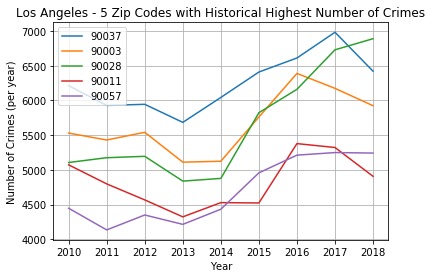

In [17]:
# plot lines
plot_90037 = plt.plot(zip_90037['year'],zip_90037['dr_no'],label=90037)
plot_90003 = plt.plot(zip_90003['year'],zip_90003['dr_no'],label=90003)
plot_90028 = plt.plot(zip_90028['year'],zip_90028['dr_no'],label=90028)
plot_90011 = plt.plot(zip_90011['year'],zip_90011['dr_no'],label=90011)
plot_90057 = plt.plot(zip_90057['year'],zip_90057['dr_no'],label=90057)
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - 5 Zip Codes with Historical Highest Number of Crimes')
plt.legend()
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - 5 Zip Codes with Historical Highest Number of Violent Crimes.png')
# show plot
plt.show()

In [18]:
# chart review:
# - disproportionate increase for zip code 90028
# - 2018 from the top 5 crime perspective shows a general decrease of crime

In [19]:
# violent crime historical review ###############################################

In [20]:
# per initial list review with team member with history in law enforcement
violent_crime_list = [ 110, 113,121,122,210,220,230,231,235,236,250,251,434,435,436,451,753,821,860,910,920]
# type(violent_crime)

In [30]:
violent_crime_df = results_df[results_df["crm_cd"].isin(violent_crime_list)]
# remove 2019
violent_crime_df = violent_crime_df.loc[violent_crime_df['year'] != 2019]
violent_crime_df

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_desc,date_occ,date_rptd,dr_no,location,location_1,...,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year
4,4,7.0,Wilshire,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,"{'type': 'Point', 'coordinates': [-118.3353, 3...",...,2000,43.0,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010
5,5,7.0,Wilshire,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700720,4400 W WASHINGTON BL,"{'type': 'Point', 'coordinates': [-118.3353, 3...",...,2000,44.0,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010
6,6,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-04-12T00:00:00.000,2010-04-12T00:00:00.000,100700734,CLOVERDALE AV,"{'type': 'Point', 'coordinates': [-118.3462, 3...",...,155,24.0,O,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0623,-118.3462,90036,2010
14,14,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-06-27T00:00:00.000,2010-06-27T00:00:00.000,100700892,1600 S HIGHLAND AV,"{'type': 'Point', 'coordinates': [-118.3441, 3...",...,410,31.0,B,F,KNIFE WITH BLADE 6INCHES OR LESS,200.0,34.0461,-118.3441,90019,2010
15,15,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-01T00:00:00.000,2010-07-01T00:00:00.000,100700898,4800 W WASHINGTON BL,"{'type': 'Point', 'coordinates': [-118.3435, 3...",...,715,63.0,W,M,STICK,308.0,34.0399,-118.3435,90019,2010
16,16,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-02T00:00:00.000,2010-07-02T00:00:00.000,100700902,WASHINGTON,"{'type': 'Point', 'coordinates': [-118.3398, 3...",...,200,39.0,O,M,HAND GUN,102.0,34.0399,-118.3398,90019,2010
19,19,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-15T00:00:00.000,2010-07-15T00:00:00.000,100700936,1500 MEADOWBROOK AV,"{'type': 'Point', 'coordinates': [-118.351, 34...",...,2315,61.0,W,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0465,-118.3510,90019,2010
21,21,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-05-13T00:00:00.000,2010-08-05T00:00:00.000,100700987,4000 W JOHNNIE COCH AV,"{'type': 'Point', 'coordinates': [-118.3269, 3...",...,2100,39.0,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0418,-118.3269,90018,2010
22,22,7.0,Wilshire,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-08-19T00:00:00.000,2010-08-19T00:00:00.000,100701019,700 N LA CIENEGA BL,"{'type': 'Point', 'coordinates': [-118.3765, 3...",...,145,21.0,W,M,BOTTLE,212.0,34.0842,-118.3765,90069,2010
23,23,7.0,Wilshire,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-08-20T00:00:00.000,2010-08-20T00:00:00.000,100701021,400 N ROSSMORE AV,"{'type': 'Point', 'coordinates': [-118.3273, 3...",...,115,33.0,W,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0776,-118.3273,90038,2010


In [31]:
# group by year / zipcode ; count number of crimes (dr_no)
zip_crime_v_intermediate = violent_crime_df.sort_values(by=['zipcode'])
aggregation = { 
     'dr_no': 'count' 
}
zip_crime_v = zip_crime_v_intermediate.groupby(['zipcode']).agg(aggregation)
zip_crime_v = zip_crime_v.sort_values(by=['dr_no'], ascending=False)
zip_crime_v.reset_index(level=0, inplace=True)
zip_crime_v.head()

,zipcode,dr_no
0,90037,11300
1,90003,9915
2,90011,8158
3,90057,7610
4,90062,7387


In [32]:
zip_crime_top_v = zip_crime_v[:5]
zip_crime_top_v

,zipcode,dr_no
0,90037,11300
1,90003,9915
2,90011,8158
3,90057,7610
4,90062,7387


In [33]:
zip_crime_v.tail()

,zipcode,dr_no
164,90262,1
165,90740,1
166,90221,1
167,90805,1
168,93551,1


In [34]:
# get top into array to process zipcodes for line plot
zip_top_v = zip_crime_top_v.zipcode.unique()
zip_top_v

array([90037, 90003, 90011, 90057, 90062], dtype=int64)

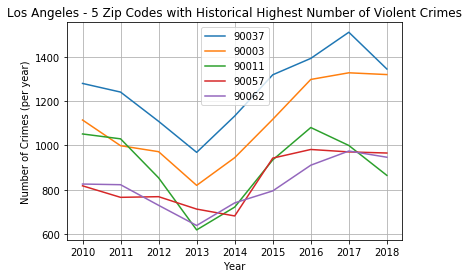

In [35]:
aggregation = { 
     'dr_no': 'nunique' 
}

zip_90037_v = violent_crime_df[violent_crime_df.zipcode == 90037].groupby(['year','zipcode']).agg(aggregation)
zip_90003_v = violent_crime_df[violent_crime_df.zipcode == 90003].groupby(['year','zipcode']).agg(aggregation)
zip_90011_v = violent_crime_df[violent_crime_df.zipcode == 90011].groupby(['year','zipcode']).agg(aggregation)
zip_90057_v = violent_crime_df[violent_crime_df.zipcode == 90057].groupby(['year','zipcode']).agg(aggregation)
zip_90062_v = violent_crime_df[violent_crime_df.zipcode == 90062].groupby(['year','zipcode']).agg(aggregation)

zip_90037_v.reset_index(level=0, inplace=True)
zip_90003_v.reset_index(level=0, inplace=True)
zip_90011_v.reset_index(level=0, inplace=True)
zip_90057_v.reset_index(level=0, inplace=True)
zip_90062_v.reset_index(level=0, inplace=True)

# plot lines
plot_90037_v = plt.plot(zip_90037_v['year'],zip_90037_v['dr_no'],label=90037)
plot_90003_v = plt.plot(zip_90003_v['year'],zip_90003_v['dr_no'],label=90003)
plot_90011_v = plt.plot(zip_90011_v['year'],zip_90011_v['dr_no'],label=90011)
plot_90057_v = plt.plot(zip_90057_v['year'],zip_90057_v['dr_no'],label=90057)
plot_90062_v = plt.plot(zip_90062_v['year'],zip_90062_v['dr_no'],label=90062)
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - 5 Zip Codes with Historical Highest Number of Violent Crimes')
plt.legend()
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - 5 Zip Codes with Historical Highest Number of Crimes.png')
# show plot
plt.show()

In [36]:
# chart review:
# - 2018 from the top 5 crime perspective shows a general decrease of crime
# = top 5 zip code 90028 from an overall crime perspective is not in top 5 from a violent crime perspective

In [37]:
# violent crime historical review overall ###############################################

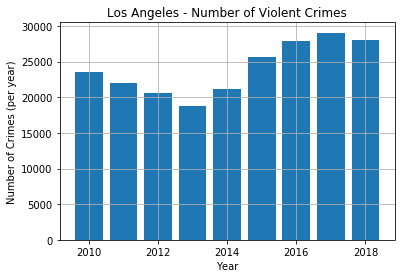

In [38]:
aggregation = { 
     'dr_no': 'nunique' 
}

overall_v = violent_crime_df.groupby(['year']).agg(aggregation)

overall_v.reset_index(level=0, inplace=True)

# plot lines
plot_overall_v = plt.bar(overall_v['year'],overall_v['dr_no'])
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - Number of Violent Crimes')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - Overall Number of Violent Crimes.png')
# show plot
plt.show()

In [39]:
overall_v

,year,dr_no
0,2010,23571
1,2011,21999
2,2012,20585
3,2013,18722
4,2014,21191
5,2015,25586
6,2016,27943
7,2017,29045
8,2018,27991


In [40]:
vc_2018vs2017 = (( overall_v['dr_no'][8] / overall_v['dr_no'][7]  ) - 1 ) * 100
vc_2018vs2017

-3.6288517817180233

In [41]:
# chart review:
# - 2018 versus 2017 from an overall violent crime perspective: from 29,045 to 27,991: decrease of 3.63 %
#   In line with article 27,246 for 2018 and a decrease of near to 4 %
#   article: https://www.latimes.com/local/lanow/la-me-lapd-crime-stats-20181229-story.html
# - Note: additional analysis done on reporting in 2015 showing inaccurate / underreporting of violent crimes
#   article: https://www.latimes.com/local/cityhall/la-me-crime-stats-20151015-story.html
#            https://github.com/datadesk/lapd-crime-classification-analysis
# - Note: changing perceptions on use and distribution of drugs and legalization can impact numbers

In [42]:
# violent crime by zip code historical review overall ###############################################

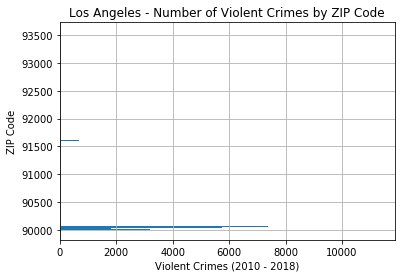

In [44]:
aggregation = { 
     'dr_no': 'nunique' 
}

zipcode_hist_v = violent_crime_df.groupby(['zipcode']).agg(aggregation)
zipcode_hist_v = zipcode_hist_v.sort_values(by=['dr_no'], ascending=True)
zipcode_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_zipcode_hist_v = plt.barh( zipcode_hist_v['zipcode'], zipcode_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by ZIP Code')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - Number of Violent Crimes by ZIP Code.png')
# show plot
plt.show()
# to do: changes seemed to have had an impact

In [45]:
total_v =  zipcode_hist_v.sum(axis = 0, skipna = True).dr_no

In [46]:
zipcode_hist_v['perc'] = zipcode_hist_v['dr_no'] / total_v * 100
zipcode_hist_v = zipcode_hist_v.sort_values(by=['dr_no'], ascending=False)
zipcode_hist_v.reset_index(level=0, inplace=True)

# zipcode_hist_v

In [47]:
len(zipcode_hist_v)
total_10perc = 0
total_20perc = 0
i_10 = int(len(zipcode_hist_v) * 10 / 100) #10 %
i_20 = int(len(zipcode_hist_v) * 20 / 100) #20 %
counter=0
for index, row in zipcode_hist_v.iterrows():
    if counter < i_10:
        total_10perc = total_10perc + row.perc            
    if counter < i_20:
        total_20perc = total_20perc + row.perc
    counter = counter + 1

In [48]:
print(total_10perc)
print(total_20perc)

43.65678359252746
65.1872060120111


In [49]:
# the top 10 % of the zip codes account for 43.66 % of violent crime
# the top 20 % of the zip codes account for 65.19 % of violent crime

In [55]:
# violent crime by victim gender historical review overall ###############################################

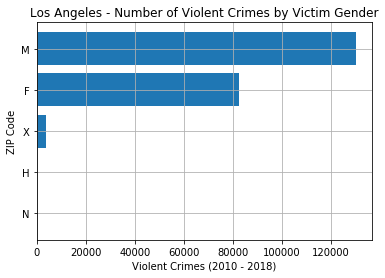

In [56]:
aggregation = { 
     'dr_no': 'nunique' 
}

vict_sex_hist_v = violent_crime_df.groupby(['vict_sex']).agg(aggregation)
vict_sex_hist_v = vict_sex_hist_v.sort_values(by=['dr_no'], ascending=True)
vict_sex_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_vict_sex_hist_v = plt.barh( vict_sex_hist_v['vict_sex'], vict_sex_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by Victim Gender')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - Number of Violent Crimes by Victim Gender.png')
# show plot
plt.show()

In [57]:
total_vict_sex_v =  vict_sex_hist_v.sum(axis = 0, skipna = True).dr_no
vict_sex_hist_v['perc'] = vict_sex_hist_v['dr_no'] / total_vict_sex_v * 100

vict_sex_hist_v

,vict_sex,dr_no,perc
0,N,1,0.000462
1,H,14,0.006466
2,X,3636,1.679198
3,F,82641,38.165721
4,M,130240,60.148154


In [58]:
# expectation was to see a higher percentage of female victim violent crime, but graph and table show a 60.15% male victim of violent crime rate.

In [59]:
# violent crime by victim descent historical review overall ###############################################

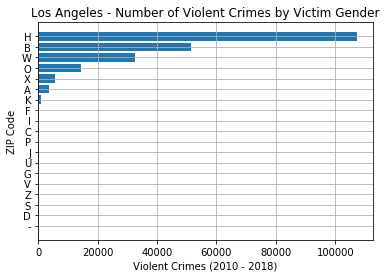

In [60]:
aggregation = { 
     'dr_no': 'nunique' 
}

vict_descent_hist_v = violent_crime_df.groupby(['vict_descent']).agg(aggregation)
vict_descent_hist_v = vict_descent_hist_v.sort_values(by=['dr_no'], ascending=True)
vict_descent_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_vict_descent_hist_v = plt.barh( vict_descent_hist_v['vict_descent'], vict_descent_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by Victim Gender')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig('Los Angeles - Number of Violent Crimes by Victim Descent.png')
# show plot
plt.show()

In [61]:
total_vict_descent_v =  vict_descent_hist_v.sum(axis = 0, skipna = True).dr_no
vict_descent_hist_v['perc'] = vict_descent_hist_v['dr_no'] / total_vict_descent_v * 100

vict_descent_hist_v

,vict_descent,dr_no,perc
0,-,1,0.000462
1,D,1,0.000462
2,S,4,0.001847
3,Z,8,0.003695
4,V,10,0.004618
5,G,12,0.005542
6,U,14,0.006466
7,J,15,0.006928
8,P,19,0.008775
9,C,49,0.022630


In [ ]:
# expected hispanic / black victims to be close: 49.56 % of violent crime victims are of hispanic descent

In [ ]:
# income

In [ ]:
# home value